# Thrust and the rocket equation

In [60]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

In [61]:
# these lines are only for helping improve the display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

## Example: Numerical integration of vertical launch

Determine the burnout velocity and maximum height achieved by launching 
the German V-2 rocket, assuming a vertical launch. Take into account drag,
the variation of atmospheric density with altitude, and the variation of gravity
with altitude. Use a forward difference numerical scheme (i.e., forward Euler) to
solve the system of equations.

Given data:
- specific impulse: $I_{\text{sp}}$ = 250 sec
- initial mass: $m_0$ = 12700 kg
- propellant mass: $m_p$ = 8610 kg
- burn time: $t_b$ = 60 sec
- maximum body diameter: $D$ = 5 feet 4 inches (5.333 ft)
- height: $H$ = 46 feet

{numref}`V2-diagrams` shows how the coefficients of lift and drag vary
with Mach number and angle of attack.

:::{figure} V2-diagrams
<img src="../images/V2-lift-drag-coefficient.png" alt="V2 rocket coefficients of lift and drag" class="bg-primary mb-1" width="500px" align="center">

Variation of coefficients of drag and lift with Mach number and angle of attack,
for the German V-2 rocket. Source: Sutton and Biblarz {cite}`sutton2016rocket`.
:::

Let's set up the system of ordinary differential equations for velocity ($m$),
altitude ($h$), and mass ($m$) that describes this problem:

$$
\begin{align*}
\frac{dv}{dt} &= -\frac{I_{\text{sp}} g_0}{m} \frac{dm}{dt} - \frac{1}{2} \rho (h) v^2 A C_D (h) - g(h) \\
\frac{dh}{dt} &= v \\
\frac{dm}{dt} &= -\dot{m} = -\frac{m_p}{t_b} \;,
\end{align*}
$$

where we obtained the last equation by recognizing that

$$
\begin{align*}
m_f &= m_0 - \dot{m} t_b \\
m_p &= m_0 - m_f = \dot{m} t_b \\
\dot{m} &= \frac{m_p}{t_b}
\end{align*}
$$

for steady burning.
In the above, $g_0$ is the reference acceleration due to 
gravity (9.80065 m/s<sup>2</sup>), $\rho(h)$ is the atmospheric density,
$A$ is the cross-sectional area of the body, 
$C_D$ is the drag coefficient, and
$g(h)$ is the (varying) acceleration due to gravity.

**Density and gravity:**
To move forward, we need to describe how to evaluate density, 
gravitational acceleration, and the coefficient of drag at any instant in time.
The first two are known functions of altitude:

$$
\begin{align*}
\rho (h) &= \rho_0 e^{-h / H_n} \\
g(h) &= g_0 \left( \frac{R_0}{R_0 + h} \right)^2 \;,
\end{align*}
$$

where $\rho_0$ = 1.225 kg/m<sup>3</sup> is the density at sea level, 
$H_n$ = 10.4 km is the height scale of the exponential fall,
$R_0$ = 6378.388 km is the mean radius of Earth, and
$g_0$ = 9.80665 m/s<sup>2</sup> is the sea-level acceleration due to gravity.

### Coefficient of drag

Coefficient of drag is more difficult to handle, since it depends on angle of
attack and Mach number: $C_D = C_D(M, \alpha)$. For vertical flight, the angle
of attack is zero ($\alpha = 0$), but the Mach number will be changing both as
the vehicle speed changes and the atmospheric conditions change with altitude:

$$
M = \frac{v}{\sqrt{ \gamma p(h) / \rho(h) }}
$$

**Option 1:** 
As a first approximation, we could simply assume a constant value for coefficient of drag.
For example, before and after the transonic regime (where Mach number approaches 1),
$C_D \approx 0.15$.

**Option 2:** 
If we want to more-accurately capture the increase in coefficient of drag as
the vehicle approaches a sonic velocity, and then the relaxation when supersonic,
we need to capture the dependence of $C_D$ on Mach number.

First, we already have an expression for $\rho(h)$, but we also need an expression
for pressure. We can use a similar exponential approximation:

$$
p(h) = p_0 e^{-h / H_p} \;,
$$

where $p_0$ = 101325 Pa is the sea-level standard atmospheric pressure
and $H_p$ = 8.4 km.
With $\gamma = 1.4$ being a reasonable constant, we can now calculate Mach number based on velocity and altitude.

```{sidebar} Exponential approximations
The exponential approximations we use for the variation of density and pressure
in the atmosphere are only so good; more-accurate calculations would need to
use a better model.
```

Now, we need to obtain a functional dependence of $C_D (M)$;
based on {numref}`V2-diagrams`, we see that the relationship is fairly complex.
The "easiest" way to create a function for $C_D (M)$ is to:
- Extract data points from the plot manually, using a tool such as [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/index.html)
- Perform a spline interpolation on the data points, using a function such as `spline` in Matlab or `scipy.interpolate.UnivariateSpline` in Python.

Let's see this in action, using data extracted manually from the source figure:

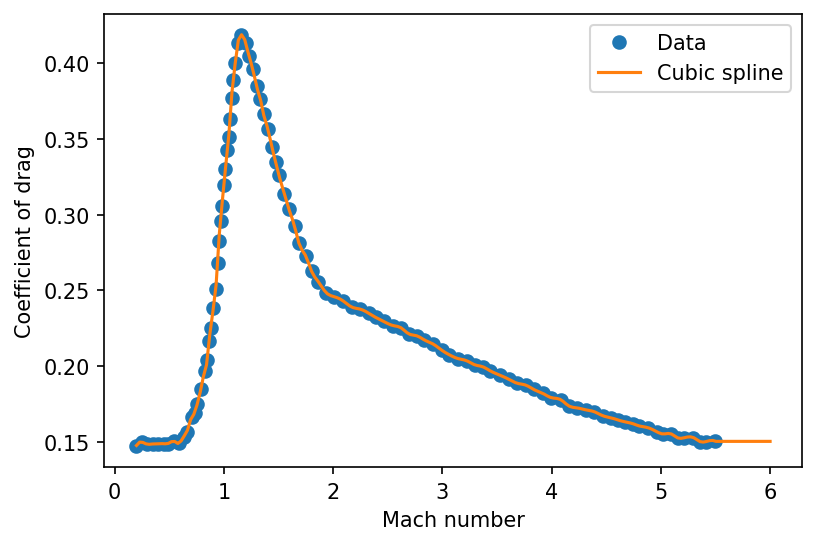

In [62]:
import numpy as np
from scipy.interpolate import UnivariateSpline

data = np.genfromtxt('coefficient-drag.csv', delimiter=',')

coefficient_drag = UnivariateSpline(data[:,0], data[:,1], s=0, ext='const')

mach = np.linspace(0.2, 6, num=200, endpoint=True)
plt.plot(data[:,0], data[:,1], 'o', mach, coefficient_drag(mach), '-')
plt.xlabel('Mach number')
plt.ylabel('Coefficient of drag')
plt.legend(['Data', 'Cubic spline'])
plt.show()

In Matlab, the equivalent fit can be done with:

```{code-block} matlab
data = readmatrix('coefficient-drag.csv');
plot(data(:,1), data(:,2), 'o'); hold on

coef_drag = spline(data(:,1), data(:,2));
xx = linspace(0.2, 5, 500);
plot(xx, ppval(coef_drag,xx), '-');
```

Now that we have a fully defined system of equations, we need a numerical method to integrate.

We can first use a forward difference scheme, also known as the forward Euler method:

$$
\mathbf{z}_{i+1} = \mathbf{z}_i + \Delta t \, \mathbf{f} \left( t_i, \mathbf{z}_i \right) \;,
$$

where $\mathbf{z}_{i}$ is the vector of state variables at time $t_i$,
$\Delta t$ is the time step size, and
$\mathbf{f}$ represents the vector of time derivatives.

To implement, we need to create a function to evaluate the time derivatives, and then specify initial conditions for velocity, altitude, and mass:
$v(t = 0) = 0$, $h(t = 0) = 0$, and $m(t = 0) = m_0$.

In [63]:
from scipy.integrate import solve_ivp

def vertical_launch(t, y, spec_impulse, mass_prop, time_burn, diameter, coef_drag):
    '''Evaluates system of time derivatives for velocity, altitude, and mass.
    '''
    radius_earth = 6378.388 * 1e3
    gravity_ref = 9.80665
    density_ref = 1.225
    pressure_ref = 101325
    gamma = 1.4
    height_den = 10400
    height_pres = 8400
    
    v = y[0]
    h = y[1]
    m = y[2]
    
    gravity = gravity_ref * (radius_earth / (radius_earth + h))**2
    density = density_ref * np.exp(-h / height_den)
    pressure = pressure_ref * np.exp(-h / height_pres)
    
    mach = v / np.sqrt(gamma * pressure / density)
    area = np.pi * diameter**2 / 4
    drag = 0.5 * density * v**2 * area * coef_drag(mach)
    
    dmdt = -mass_prop / time_burn
    dvdt = (-spec_impulse * gravity_ref / m) * dmdt - drag / m - gravity
    dhdt = v
    
    return [dvdt, dhdt, dmdt]

# given constants
spec_impulse = 250
mass_initial = 12700
mass_propellant = 8610
time_burn = 60
diameter = 1.626

sol = solve_ivp(
    vertical_launch, [0, time_burn], [0, 0, mass_initial], method='RK45', 
    args=(spec_impulse, mass_propellant, time_burn, diameter, coefficient_drag),
    dense_output=True
    )

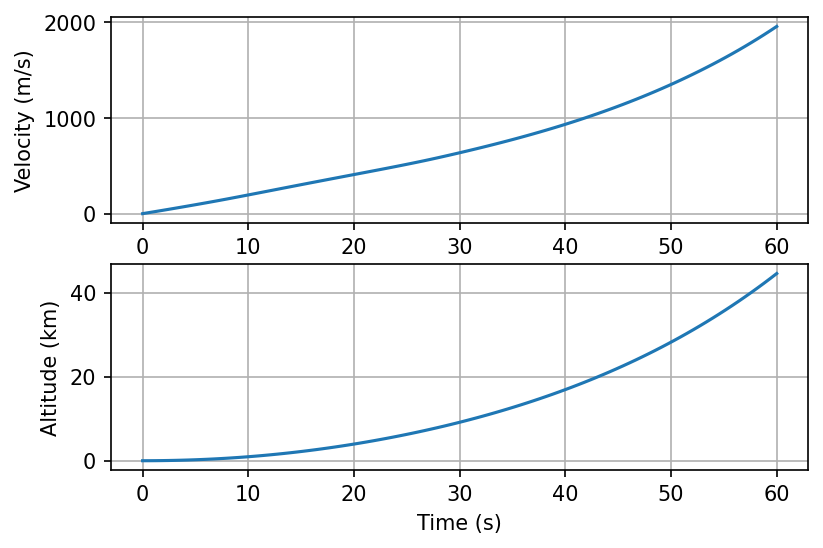

Burnout velocity:  1956.11 m/s
Burnout altitude:  44.54 km


In [66]:
time = np.linspace(0, time_burn, 100)
z = sol.sol(time)

fig, axes = plt.subplots(2, 1)

axes[0].plot(time, z[0, :])
axes[0].set_ylabel('Velocity (m/s)')
axes[0].grid(True)

axes[1].plot(time, z[1, :] / 1000)
axes[1].set_ylabel('Altitude (km)')
axes[1].set_xlabel('Time (s)')
axes[1].grid(True)

plt.show()

print(f'Burnout velocity: {z[0,-1]: 5.2f} m/s')
print(f'Burnout altitude: {z[1,-1]/1000: 5.2f} km')

In Matlab, the above could be done with:

```{code-block} matlab
clear; clc;

g0 = 9.80665;
Re = 6378.388 * 1e3;

Isp = 250;
m0 = 12700;
mp = 8610;
tb = 60;
D = 1.626;

data = readmatrix('coefficient-drag.csv');
plot(data(:,1), data(:,2), 'o'); hold on

coef_drag = spline(data(:,1), data(:,2));
xx = linspace(0.2, 5, 500);
plot(xx, ppval(coef_drag,xx), '-');

f = @(t,z) rocket(t, z, Isp, mp, tb, D, coef_drag);

[T, Z] = ode45(f, [0 0 m0], [0 tb]);

function dzdt = rocket(t, z, Isp, mp, tb, D, coef_drag)
g0 = 9.80665; Re = 6378.388 * 1e3;
mdot = mp / tb;

v = z(1);
h = z(2);
m = z(3);

g = g0 * (Re / (Re + h))^2;

rho0 = 1.225;
p0 = 101325;
Hn = 10400;
gamma = 1.4;
rho = rho0 * exp(-h / Hn);
pres = p0 + g*rho0*Hn*(exp(-h/Hn) - 1);

area = pi * D^2 / 4;
M = v / sqrt(gamma * pres / rho);
C_D = ppval(coef_drag, M);
drag = 0.5 * rho * v^2 * area * C_D;

dzdt = zeros(3,1);
dzdt(3) = -mdot;
dzdt(1) = (-Isp*g0/m)*dzdt(3) - drag/m - g;
dzdt(2) = v;

end
```